# Introduction
We are given IMU data that is collected by a robot while "walking" on different types of floor surface. In this notebook, we are going to train our machine learing model on the data and, hopefully, be able to correctly predict the type of floor surface when given a brand new set of IMU data.

To complete such task, I will be doing Feature Engineering, using several machine learning models to train the data and test the model using cross validation to see which model has the most accurate predicting power for our data. Specific detail, implementation and references will be displayed in later sections

# Data
In this section, we will take a look into the data that is provided to us, find out what type of machine learning problem this task it and make sense of what each attribut means

### 1. Loading libaries

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn import metrics

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#print(os.listdir("../input/career-con-2019"))

# Any results you write to the current directory are saved as output.

print("Libaries loaded.")

Libaries loaded.


### 2. Loading data

In [0]:
X_train = pd.read_csv("../input/career-con-2019/X_train.csv")
Y_train = pd.read_csv("../input/career-con-2019/y_train.csv")

print("Data loaded.")

Data loaded.


### 3. Exploring data

In [0]:
X_train

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435


There are 3810 series of input data, which means that our data provider performed 3810 walks. Each serie contains 128 sets of measurements, which means that measurements were taken 128 times during the course of a walk. These measurements consist of 4 orientation measurement, 3 angular velocity measurement and 3 linear acceleration measurement.

In [0]:
Y_train

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
...,...,...,...
3805,3805,55,tiled
3806,3806,67,wood
3807,3807,48,fine_concrete
3808,3808,54,tiled


Same as the input, there are 3810 series output data, each indicates what one of the 9 surfaces each walk was performed on. Group_id indicates which specific surface that walk was performed on. An example could better explain the difference between surface and group_id. Let's take serie 1 and 2 for example, they have the same surface value, which is "concrete", but different group_id value, 31 for serie 1 and 20 for serie 2. This means that serie 1 and 2 are performed on two different concrete surface. On the other hand, if two series have the same surface and group_id value, serie 1 and 3 for example, it means that they are both performed on same specific concrete surface. Below is a simple count on the amount of walks that were performed on each surface.

Our task is to take new set of input data and predict which 1 of the 9 types of floor that the robot was walking on when the each set of data was collected. From the description above, we can conclude that this task is a multiclass classification problem. 

# Data Preprocessing 
After exploring the data, lots question emerged. It is fairly easier to understand linear acceleration and angular velocity, but what exactly are orientations and why there are 4 of them? Additionally, we can see that input data and output data has different amount of rows, more specifically, a serie has exactly 1 entry in output data but 128 entries in input data. In this section, we will address these two issues one by one and perform preprocessing to prepare our data to a fit our machine learning model.

### 1. Converting orientations

After researching (reference 1, 2 and 3), I was able to make sense of what we could do with the orientation values that are provided to us. In a nutshell, we could convert the 4-degree orientation value into 3-degree euler angle value for better understanding. Two functions defined below are doing such job for each entry in input data. They take the 4 orientation values of each row, output 3 new values: roll, pitch and yaw, and add them to corresponding row.

In [0]:
##  This function takes 4 orientation values as input
##  and calculates roll, pitch and yaw value 
def quaternion_to_euler(x, y, z, w):
    sinr_cosp = 2.0 * (w * x + y * z)
    cosr_cosp = 1.0 - 2.0 * (x * x + y * y)
    roll = math.atan2(sinr_cosp, cosr_cosp)
    
    sinp = 2.0 * (w * y - z * x)
    if sinp > 1.0:
        sinp = 1.0
    if sinp < -1.0:
        sinp = -1.0
    pitch = math.asin(sinp)
    
    siny_cosp = 2.0 * (w * z + x * y)
    cosy_cosp = 1.0 - 2.0 * (y * y + z * z)
    yaw = math.atan2(siny_cosp, cosy_cosp)
    
    return roll, pitch, yaw

In [0]:
##  This function takes pd.dataframe as input, extracts orientation value for each entry,
##  calls quaternion_to_euler and add three new attribues to each entry along with 
##  corresponding values.
def add_euler_features(dataframe):
    x, y, z, w = dataframe["orientation_X"].tolist(), dataframe["orientation_Y"].tolist(), dataframe["orientation_Z"].tolist(), dataframe["orientation_W"].tolist()
    rolls, pitches, yaws = [], [], []
    for i in range(len(x)):
        roll, pitch, yaw = quaternion_to_euler(x[i], y[i], z[i], w[i])
        rolls.append(roll)
        pitches.append(pitch)
        yaws.append(yaw)
    dataframe["roll"] = rolls
    dataframe["pitch"] = pitches
    dataframe["yaw"] = yaws

Apply above funtions to X_train.

In [0]:
add_euler_features(X_train)
print("Added euler angels to X_train")

Added euler angels to X_train


Let's take a look at the new X_train dataset

In [0]:
X_train

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,roll,pitch,yaw
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,2.843272,-0.024668,1.396664
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,2.843199,-0.024662,1.396646
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,2.843224,-0.024728,1.396682
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,2.843186,-0.024770,1.396721
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,2.843195,-0.024784,1.396693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063,2.907700,-0.018571,-1.768404
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257,2.907732,-0.018575,-1.768079
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443,2.907657,-0.018699,-1.767856
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435,2.907480,-0.018655,-1.767534


Three new attribues, roll, pitch and yaw, were added to each entry in X_train dataset.

### 2. Feature Engineering

As stated in the introduction of this section, our sample data and target data do not have the same amount of rows. This is because our data provider recorded 128 times during a course of walk, but there is only one output for one walk. Therefore, we need to find a way to crunch 128 rows of data for each serie into 1 row for each serie. After researching on "common numerical feature aggregate functions", I found out that "for numerical features, average and sum functions are usually convenient options"(reference 7). Therefore, that is exactly what I have done in function below, I grouped all of our input data by their series_id and took mean and sum of each attributes within each serie, and outputed them into a new dataframe. The returned dataframe will be our new sample data for our machine learning model.

In [0]:
def feature_engineering(dataframe):
    ret_dataframe = pd.DataFrame()
    
    for column in dataframe.columns:
        if column == "row_id" or column == "series_id" or column == "measurement_number":
            continue
        ret_dataframe[column + "_mean"] = dataframe.groupby(["series_id"])[column].mean()
        ret_dataframe[column + "_sum"] = dataframe.groupby(["series_id"])[column].sum()

    return ret_dataframe

##  This fucntion was defined under the influence of reference 3

Apply above function to X_train.

In [0]:
X_train = feature_engineering(X_train)
print("Applied feature engineering to X_train")

Applied feature engineering to X_train


Let's take a look at the new X_train data.

In [0]:
X_train

,orientation_X_mean,orientation_X_sum,orientation_Y_mean,orientation_Y_sum,orientation_Z_mean,orientation_Z_sum,orientation_W_mean,orientation_W_sum,angular_velocity_X_mean,angular_velocity_X_sum,...,linear_acceleration_Y_mean,linear_acceleration_Y_sum,linear_acceleration_Z_mean,linear_acceleration_Z_sum,roll_mean,roll_sum,pitch_mean,pitch_sum,yaw_mean,yaw_sum
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-97.10922,-0.634008,-81.15298,-0.105474,-13.500690,-0.106470,-13.628110,-0.002481,-0.317527,...,2.984195,381.976947,-9.320391,-1193.010000,2.841734,363.741973,-0.025037,-3.204732,1.396035,178.692530
1,-0.958606,-122.70162,0.241867,30.95897,0.031650,4.051239,-0.146876,-18.800070,0.004605,0.589410,...,2.768193,354.328696,-9.388899,-1201.779100,2.840129,363.536528,-0.010369,-1.327174,-0.492731,-63.069540
2,-0.512057,-65.54334,-0.846171,-108.30988,-0.129371,-16.559440,-0.071082,-9.098478,0.002646,0.338645,...,2.886745,369.503305,-9.395783,-1202.660200,2.845529,364.227651,-0.012195,-1.560956,2.055021,263.042744
3,-0.939169,-120.21364,0.310140,39.69794,0.038955,4.986241,-0.142319,-18.216810,0.000624,0.079866,...,2.657922,340.214058,-9.451164,-1209.749000,2.845777,364.259493,-0.015107,-1.933725,-0.635656,-81.363929
4,-0.891301,-114.08647,0.428144,54.80246,0.060056,7.687225,-0.136460,-17.466930,0.006969,0.892016,...,2.981498,381.631730,-9.349988,-1196.798500,2.842442,363.832589,-0.009793,-1.253551,-0.894147,-114.450875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,-0.228787,-29.28475,0.961730,123.10148,0.144690,18.520330,-0.042361,-5.422159,0.002519,0.322397,...,2.745177,351.382690,-9.465299,-1211.558256,2.839285,363.428462,-0.015273,-1.954967,-2.672166,-342.037278
3806,0.542262,69.40952,0.826590,105.80358,0.129890,16.625920,0.076335,9.770885,-0.000453,-0.057970,...,2.900305,371.239000,-9.367247,-1199.007600,2.839466,363.451624,-0.014674,-1.878226,1.982632,253.776906
3807,-0.416511,-53.31344,0.895374,114.60787,0.140185,17.943660,-0.070016,-8.962046,0.031838,4.075327,...,3.660786,468.580635,-9.192466,-1176.635710,2.826992,361.854985,-0.008638,-1.105621,-2.269413,-290.484806


# Fitting & Predicting

Like I stated at the end of Data section, this task is a multiclass classification problem, therefore, in this section, I will be training 4 classic multiclass classifiers including K-Nearest Neighbors Classifier, Support Vector Machine Classifier, Decision Tree Classifier and Randon Forest Classifier. Addtionally, I will perform cross validation on each classifier to present their predciting power. Cross validation will be done by spliting our preprocessed input data and given output data into training set and test set, train each classifier using training input data and output data, predict an output using test input data and validate the predicted output with test output data using sklearn.metrics. We will perform such operation 10 times for each classifier and produce an average accuracy for each classifier. 

The reason that I did not use dataset provided by the TAs to test accuracy is because I think 20 groups of data is small compares to the total of 3810 groups. Addtionally, there is not enough randomness in the testing data provided by the TAs. I also believe presenting the average accuracy could better reflect the performance for each model. 

Since classifiers can only deal with numerical data, we will first transform "surface" data from categorical data to numerical data. 

In [0]:
lableDict = {"concrete": 0, "soft_pvc": 1, "wood": 2, "tiled": 3, "fine_concrete": 4, 
             "hard_tiles_large_space": 5, "soft_tiles": 6, "carpet": 7, "hard_tiles": 8}
def encodeSurface(y_dataframe):
    surface = y_dataframe["surface"].tolist()
    encodedSurface = []
    for i in range(len(surface)):
        encodedSurface.append(lableDict[surface[i]])
    y_dataframe["encoded_surface"] = encodedSurface

encodeSurface(Y_train)
Y_train

,series_id,group_id,surface,encoded_surface
0,0,13,fine_concrete,4
1,1,31,concrete,0
2,2,20,concrete,0
3,3,31,concrete,0
4,4,22,soft_tiles,6
...,...,...,...,...
3805,3805,55,tiled,3
3806,3806,67,wood,2
3807,3807,48,fine_concrete,4
3808,3808,54,tiled,3


### 1. Support Vector Machine Classifier

In [0]:
svm_score = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.3)
    svm = SVC()
    svm.fit(x_train, y_train["encoded_surface"])
    svm_y_predict = svm.predict(x_test)
    svm_score.append(metrics.accuracy_score(y_test["encoded_surface"], svm_y_predict))
    print("Accuracy for round", i+1, ":",metrics.accuracy_score(y_test["encoded_surface"], svm_y_predict))
print("Average accuracy is:", sum(svm_score)/len(svm_score))

Accuracy for round 1 : 0.32808398950131235
Accuracy for round 2 : 0.30621172353455817
Accuracy for round 3 : 0.30446194225721784
Accuracy for round 4 : 0.331583552055993
Accuracy for round 5 : 0.31408573928258965
Accuracy for round 6 : 0.2887139107611549
Accuracy for round 7 : 0.3132108486439195
Accuracy for round 8 : 0.34120734908136485
Accuracy for round 9 : 0.29396325459317585
Accuracy for round 10 : 0.2922134733158355
Average accuracy is: 0.3113735783027122


To summerize what Support Vector Machine Classifier does, it creates a line or a hyperplane which separates the data into classes. However, due to the fact that we have several really similar surface type, such as concrete and fine concrete, the distribution of their data are going to be very similar. Let's use concrete and fine concrete as example and plot three features of theirs to see for ourselves.

In [0]:
X_y_train_merged = X_train.merge(y_train, on="series_id")
concrete = X_y_train_merged.loc[X_y_train_merged["surface"]=="concrete"]
fine_concrete = X_y_train_merged.loc[X_y_train_merged["surface"]=="fine_concrete"]

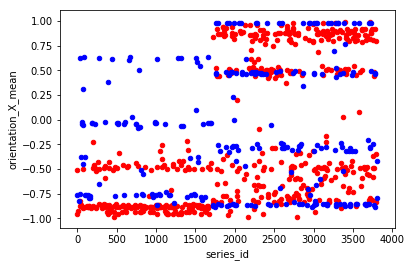

In [0]:
ax = concrete.plot(kind = "scatter", y = "orientation_X_mean", x = "series_id", color = "red")
fine_concrete.plot(kind = "scatter", y = "orientation_X_mean", x = "series_id", color = "blue", ax = ax)

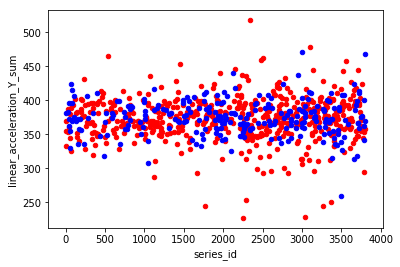

In [0]:
ax = concrete.plot(kind = "scatter", y = "linear_acceleration_Y_sum", x = "series_id", color = "red")
fine_concrete.plot(kind = "scatter", y = "linear_acceleration_Y_sum", x = "series_id", color = "blue", ax = ax)

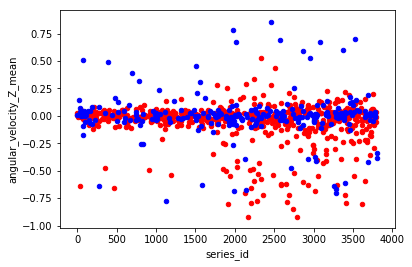

In [0]:
ax = concrete.plot(kind = "scatter", y = "angular_velocity_Z_mean", x = "series_id", color = "red")
fine_concrete.plot(kind = "scatter", y = "angular_velocity_Z_mean", x = "series_id", color = "blue", ax = ax)

From the three plot above, we can see that most data from these two classes are either overlapped with each other. Therefore, a Support Vector Machine Classifier would have a hard time generate a line or hyperplane to seperate data. A bad accuracy is expected and was produced in above code.

### 2. K-Nearest Neighbors Classifier

In [0]:
knn_score = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.3)
    knn = KNeighborsClassifier(algorithm = "auto")
    knn.fit(x_train, y_train["encoded_surface"])
    knn_y_predict = knn.predict(x_test)
    knn_score.append(metrics.accuracy_score(y_test["encoded_surface"], knn_y_predict))
    print("Accuracy for round", i+1, ":",metrics.accuracy_score(y_test["encoded_surface"], knn_y_predict))
print("Average accuracy is:", sum(knn_score)/len(knn_score))

Accuracy for round 1 : 0.6430446194225722
Accuracy for round 2 : 0.6622922134733158
Accuracy for round 3 : 0.6404199475065617
Accuracy for round 4 : 0.6167979002624672
Accuracy for round 5 : 0.642169728783902
Accuracy for round 6 : 0.6237970253718286
Accuracy for round 7 : 0.6430446194225722
Accuracy for round 8 : 0.6395450568678915
Accuracy for round 9 : 0.6342957130358705
Accuracy for round 10 : 0.642169728783902
Average accuracy is: 0.6387576552930884


What K-Nearest Neighbors does is assuming that the similarity between data is critical for identifying its class. It calculates the "distance" between a test data and all training data, pick the nearest K datapoint (in the code above, default setting for sklearn KNN is K equals to 5) and classify the test data to the most frequent label among these K datapoint.

One of the main drawback of K-Nearest Neighbor could be slow as the size of dataset grows, because it calculates the "distance" between every test data and every training data, time complexity would be O(test_size  * training_size). Fortunately, in the content of our task, 3830 sets of data is not too much to handle for this model. However, take a look at the graph we plotted in the section above again, the similarity between some of the classes could cause inaccuacy again. Becasue quite a lot of data from different class could be very "close" to each other, prediction for these classes could be hard for K-Nearest Neighbor model to identify, therefore, we can see that this model did not produce high accuracy performance as well. 

### 3. Decision Tree Classifier

In [0]:
dtree_score = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.3)
    dtree = DecisionTreeClassifier()
    dtree.fit(x_train, y_train["encoded_surface"])
    dtree_y_predict = dtree.predict(x_test)
    dtree_score.append(metrics.accuracy_score(y_test["encoded_surface"], dtree_y_predict))
    print("Accuracy for round", i+1, ":",metrics.accuracy_score(y_test["encoded_surface"], dtree_y_predict))
print("Average accuracy is:", sum(dtree_score)/len(dtree_score))

Accuracy for round 1 : 0.7471566054243219
Accuracy for round 2 : 0.7532808398950132
Accuracy for round 3 : 0.7471566054243219
Accuracy for round 4 : 0.7655293088363955
Accuracy for round 5 : 0.7357830271216098
Accuracy for round 6 : 0.7777777777777778
Accuracy for round 7 : 0.7489063867016623
Accuracy for round 8 : 0.7489063867016623
Accuracy for round 9 : 0.7340332458442694
Accuracy for round 10 : 0.7375328083989501
Average accuracy is: 0.7496062992125985


Decision Tree Classifier uses divide and conquer heuristic, it recursivly split the training data on feature that has the highest information gain till it is sufficient enough to identify different classes. When utilizing sklearn's Decision Tree Classifier, we could specify the depth of our tree, but in the code above, to reach the best accuracy possible, I did not set the depth parameter and the default setting is to expand "until all leaves are pure or until all leaves contain less than min_samples_split (default is 2) samples" (Reference[11]), where pure leaves means that all data in each leaf belong to the same class.

From the description above, we can see that the distribution of the data, unlike for Support Vector Machine and K-Nearest Neighbor, does not come into much effect for Decision Tree Classifier. Therefore, we can see that the accuracy is higher than both classifiers we tested above.

### 4. Random Forest Classifier

In [0]:
rfc_score = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.3)
    rfc = RandomForestClassifier()
    rfc.fit(x_train, y_train["encoded_surface"])
    rfc_y_predict = rfc.predict(x_test)
    rfc_score.append(metrics.accuracy_score(y_test["encoded_surface"], rfc_y_predict))
    print("Accuracy for round", i+1, ":",metrics.accuracy_score(y_test["encoded_surface"], rfc_y_predict))
print("Average accuracy is:", sum(rfc_score)/len(rfc_score))

Accuracy for round 1 : 0.8118985126859143
Accuracy for round 2 : 0.8311461067366579
Accuracy for round 3 : 0.8363954505686789
Accuracy for round 4 : 0.8223972003499562
Accuracy for round 5 : 0.8276465441819773
Accuracy for round 6 : 0.8390201224846894
Accuracy for round 7 : 0.8407699037620298
Accuracy for round 8 : 0.8346456692913385
Accuracy for round 9 : 0.8223972003499562
Accuracy for round 10 : 0.8101487314085739
Average accuracy is: 0.8276465441819774


As we all know, a forest is consist of tons of trees. Random Forest Classifier is not an exception, and the "trees" in this "forest" are Decision Tree Classifiers. Random Forest Classifier contains a random collection of Decision Tree Classifiers, it merges all Decision Trees together to reach a better accuracy, which it did as we can see that its average accuracy is almost 10 precentage points higher than Decision Tree. 

When utilizing sklearn's Random Forest Classifier, we have the option to specify the amount of Decision Tree we want to create in the "forest". In the code above, I used the default value for the amount of Decision Tree which is 100. Note that larger amount of Decision Tree would reach a higher accuracy, however, the trade off is that model will become slower as the number of tree grows. For our data, I tested using 500 Decision Trees and it was extremely slow and the accuracy is not much higher than the accuracy produced with 100 Decision Trees.

# Summary

In this project, I first explored our given data, found out the structure of it, made sense of what each feature means and identified what category of machine learning problem this task falls into. After researching, I then realized that the 4-dimension orientation features need to coverted into 3-dimension euler angles for a better understanding and usage. Addtion to generating new features, I also became aware of that our sample data need to be grouped together to be able to map our target data. To do that, I used two most common aggregate functions, according to reference 7, in grouping numeric data in feature engineering, average and sum, to generate a new sample dataset which is mappable to the target dataset.

After exploring and preprocessing the given data, I fitted the data in 4 multiclass classifiers, Support Vector Machine, K-Nearest Neighbor, Decision Tree and Randon Forest Classifier. I performed cross validation by randomly spliting our given sample data and target data into 70% of training data and 30% of testing data. I trained each classifier with training data, predicted a set of target data and calculated the accuracy by comparing the predicting target data with the testing target data. I performed such cross validation operation for 10 rounds and produced a average accuracy for each classifer. I presented the accuracy score for each round and the average score for ten round, as well as the analysis on how each classifer perform and why. 

The conclusion that I got is that, due to the nature of the given dataset, Decision Tree Classifier performed better than both Support Vector Machine and K-Nearest Neighbor. That goes without saying that Random Forest Classifier produced the highest accuracy score among all 4 classifers. 

# Reference

[1]Video about Euler Angles: https://youtu.be/ageh45rxyXU.<br>
[2]Convertion between orientation and euler: https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles.<br>
[3]Kaggle notebook that inspired quaternion_to_euler and feature_engineering: https://www.kaggle.com/gpreda/robots-need-help.<br>
[4]Article on classification type: https://towardsdatascience.com/supervised-learning-basics-of-classification-and-main-algorithms-c16b06806cd3.<br>
[5]Article on Decision Tree: https://towardsdatascience.com/decision-tree-classification-de64fc4d5aac.<br>
[6]Article on utilizing Random Forest Classifier and Cross Validation: https://www.datacamp.com/community/tutorials/random-forests-classifier-python.<br>
[7]Article on feature engineering method: https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114.<br>
[8]Article on Support Vector Machine: https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989.<br>
[9]Article on type and usage of multiclass classifier: https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/.<br>
[10]Discussion on when to use Support Vector Machine: https://www.researchgate.net/post/When_we_use_Support_Vector_machine_for_Classification.<br>
[11]Sklearn Decision Tree document: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html.<br>
[12]Sklearn KNN document: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html.<br>
[13]Sklearn SVM document: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html.<br>
[14]Article on when to use Random Forest Classifier: https://www.newgenapps.com/blog/random-forest-analysis-in-ml-and-when-to-use-it.